# Mini-Batch Gradient Descent

In this notebook, I will implement the Mini-Batch Gradient Descent algorithm. We will measure the performance of this implementation against two different functions.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from typing import Callable, Tuple, Union
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Plot MSE Loss 

Generate visualisations for the following loss function:

$$\ell = \frac{1}{2N}\sum^N_i (y_{i,pred}-y_{i,true})^2$$

where $y_{i,true}$ are the true target values, and $y_{i,pred}$ are the model predictions. For the case here, the latter quantity is given by: $y_{i,pred} = w_0 + w_1x_i$.

In [2]:
# make a simple regression dataset
X, y, coef = make_regression(n_samples=1000, n_features=1, noise=5, bias=2, coef=True, random_state=42)

In [3]:
# set the absolute maximum range for weights
w_max = 100.0

In [4]:
# create grid of model parameters
w0 = np.arange(-w_max, w_max, 0.1)
w1 = np.arange(-w_max, w_max, 0.1)
w0, w1 = np.meshgrid(w0, w1)

In [5]:
# add bias term to data
b = np.ones((X.shape[0], 1))
X = np.concatenate((b, X),axis=1)

In [6]:
# code linear model & mse loss
def model(x: np.array, w0: np.array, w1: np.array) -> np.array:
    return w0*x[0] + w1*x[1]

def loss(y: float, yp: np.array) -> np.array:
    return (yp-y)**2

In [7]:
# compute loss for our data over the model parameters
loss_mse = np.zeros(w0.shape)
for x_i,y_i in zip(X, y):
    yp_i = model(x_i, w0, w1)
    loss_mse += loss(y_i, yp_i)
loss_mse /= (2*X.shape[0])

In [8]:
loss_mse.max()

11971.040028030218

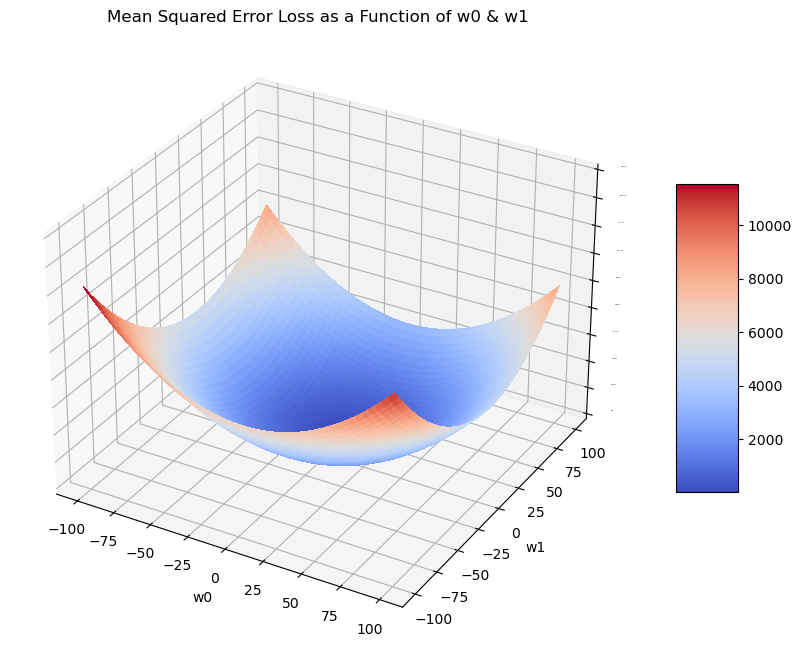

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(13,8))

# Plot the surface.
surf = ax.plot_surface(w0, w1, loss_mse, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.00, 15000.00)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# label axes
ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.tick_params(axis='z', labelsize=0)

ax.set_title('Mean Squared Error Loss as a Function of w0 & w1')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [10]:
w0_min = w0.flatten()[np.argmin(loss_mse)]
w1_min = w1.flatten()[np.argmin(loss_mse)]
print(f'min weights at: w0 = {w0_min:.2f} and w1 = {w1_min:.2f}')

min weights at: w0 = 2.00 and w1 = 16.70


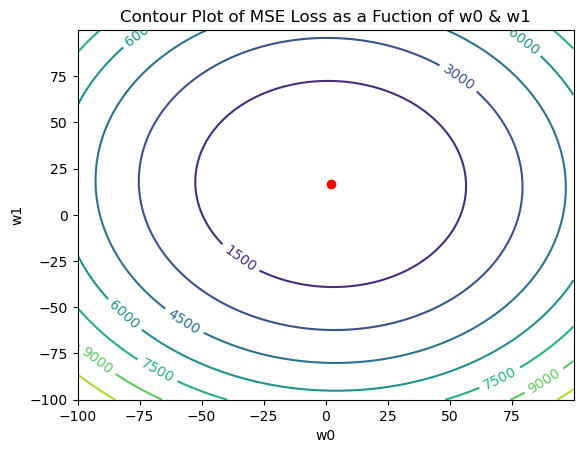

In [11]:
fig, ax = plt.subplots()
CS = ax.contour(w0, w1, loss_mse)
ax.clabel(CS, inline=True, fontsize=10)
plt.scatter(np.array([w0_min]),np.array([w1_min]),c='red')
ax.set_title('Contour Plot of MSE Loss as a Fuction of w0 & w1')
ax.set_xlabel('w0')
ax.set_ylabel('w1')
plt.show()

### Plot Trigonometric Function 

Generate visualisations for the following function:

$$\ell = \frac{1}{2N}\sum^N_i \theta_i^2sin\left(\frac{\pi \theta_i}{50}\right)$$

where $\theta_i = (y_{i,pred}-y_{i,true})$, $y_{i,true}$ are the true target values, and $y_{i,pred}$ are the model predictions. For the case here, the latter quantity is given by: $y_{pred,i} = w_0 + w_1x_i$.

In [12]:
# define new loss
def loss(y: float, yp: np.array) -> np.array:
    x = yp - y
    return (x**2)*np.sin(np.pi*x/50)

In [13]:
# compute loss for our data over the model parameters
loss_tri = np.zeros(w0.shape)
for x_i,y_i in zip(X, y):
    yp_i = model(x_i, w0, w1)
    loss_tri += loss(y_i, yp_i)
loss_tri /= (2*X.shape[0])

In [14]:
loss_tri.shape

(2000, 2000)

In [15]:
loss_tri.max()

2874.203374216204

In [16]:
loss_tri.min()

-2874.833053147669

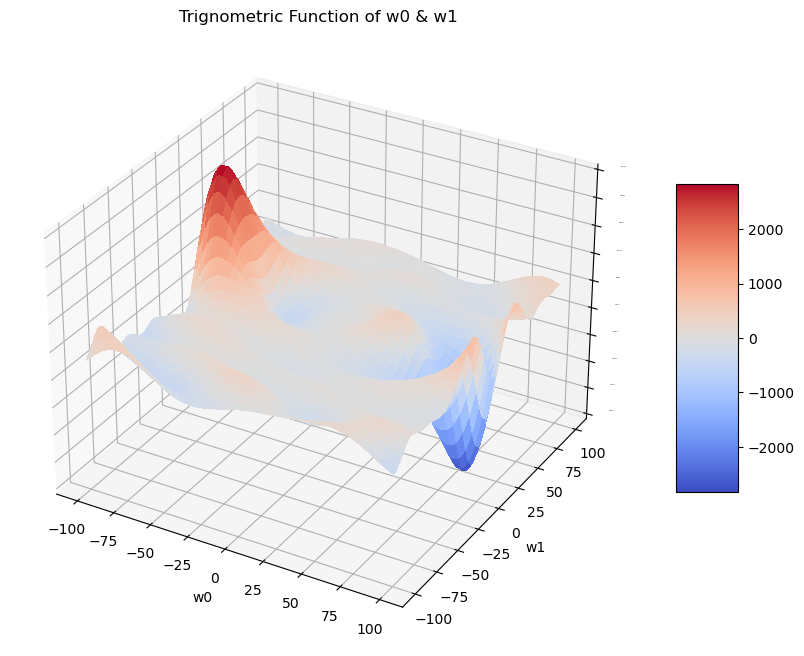

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(13,8))

# Plot the surface.
surf = ax.plot_surface(w0, w1, loss_tri, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-3000.00, 3000.00)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# label axes
ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.tick_params(axis='z', labelsize=0)

ax.set_title('Trignometric Function of w0 & w1')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [18]:
w0_min = w0.flatten()[np.argmin(loss_tri)]
w1_min = w1.flatten()[np.argmin(loss_tri)]
print(f'min weights at: w0 = {w0_min:.2f} and w1 = {w1_min:.2f}')

min weights at: w0 = 82.40 and w1 = 16.70


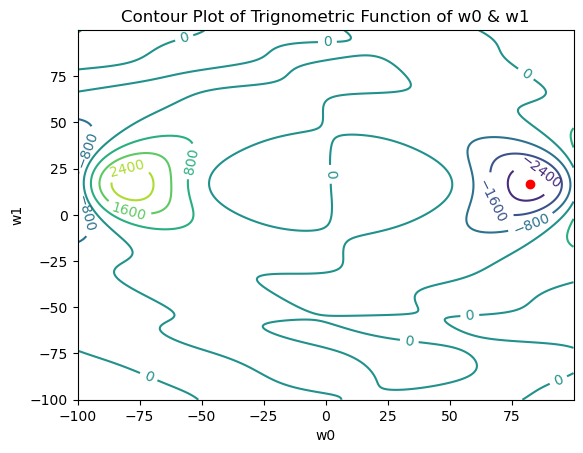

In [19]:
fig, ax = plt.subplots()
CS = ax.contour(w0, w1, loss_tri)
ax.clabel(CS, inline=True, fontsize=10)
plt.scatter(np.array([w0_min]),np.array([w1_min]),c='red')
ax.set_title('Contour Plot of Trignometric Function of w0 & w1')
ax.set_xlabel('w0')
ax.set_ylabel('w1')
plt.show()

### Mini-Batch Gradient Descent Implementation

In [29]:
def mini_batch_gradient_descent(X: np.array, 
                                y: np.array, 
                                model: Callable, 
                                Dloss: Callable, 
                                n_batches: int=10,
                                lr: float=0.1, 
                                epochs: int=500,
                                tol: float=1e-4,
                                verbose: bool=False) -> Tuple[np.array, list]:
    """
    Function to compute mini-batch gradient descent for the provided training data using the input model & loss
    
    Inputs:
        Inputs:
        X         -> predictor values
        y         -> true target values
        model     -> function to compute model predictions
        Dloss     -> function to compute the derivate of the loss function in weight space
        n_batches -> number of batches to partition the training data
        lr        -> learning rate
        epochs    -> number of epochs to train
        tol       -> tolerance for early stopping
        verbose   -> boolean to determine if extra information is printed out
        
    Output
        tuple containing a numpy array with the obtimised weights & list of the traversed path in weight space
    """
    # initialise weights 
    w_max  = 100.0
    w      = w_max*(np.random.rand(X.shape[1],1) - 0.5)
    w_path = []
    
    # cycle through epochs and update weights using batch gradient descent
    for _ in range(epochs):
        # shuffle data
        idx = np.random.permutation(X.shape[0])
        X   = X[idx,:]
        y   = y[idx].reshape(-1,1)
        # cycle through each batch of training data
        batch_size = int(X.shape[0]/n_batches)
        for i in range(n_batches):
            # set bounds for the current batch & partition data
            start = i*batch_size
            stop  = start + batch_size
            if i < (n_batches-1):
                X_batch = np.copy(X[start:stop,:])
                y_batch = np.copy(y[start:stop])
            else:
                X_batch = np.copy(X[start:,:])
                y_batch = np.copy(y[start:])
            # store current weight values
            w_path.append(w.tolist())
            # make predictions
            yp = model(X_batch,w)
            # compute the weights update & check tolerance
            dw = lr*Dloss(X_batch,y_batch,yp)
            w -= dw
            w = np.where(w > 100, 100, w)
            w = np.where(w < -100, -100, w)
            if np.linalg.norm(dw) < tol:
                break
            
    if verbose:
        yp = model(X,w)
        print(f"Error metrics: MSE = {mean_squared_error(y,yp):.2f}, MAE = {mean_absolute_error(y,yp):.2f}")
        print(f"Final weights: {float(w[0]):.2f}, {float(w[1]):.2f}")
    
    return (w, w_path)

In [26]:
def model(X: np.array, w: np.array) -> np.array:
    """
    Function to compute a linear model
    
    Inputs:
        X -> predictor values
        w -> weights
        
    Output:
        numpy array of predicted target values
    """
    return np.matmul(X,w)

In [27]:
def mse_gradient(X: np.array, y: np.array, yp: np.array) -> np.array:
    """
    Function to compute the derivative of the mse loss
    
    Inputs:
        X  -> predictor values
        y  -> true target values
        yp -> predicted target values
        
    Output
        numpy array containing the mse gradient
    """
    return 1/(X.shape[0])*np.sum(X*(yp-y).reshape(-1,1),axis=0).reshape(-1,1)

In [28]:
def trig_gradient(X: np.array, y: np.array, yp: np.array) -> np.array:
    """
    Function to compute the derivative of the trignometric function
    
    Inputs:
        X  -> predictor values
        y  -> true target values
        yp -> predicted target values
        
    Output
        numpy array containing the trignometric gradient
    """
    theta = yp - y
    return 1/(X.shape[0])*np.sum((theta*X)*(2*np.sin(np.pi*theta/50)
                                            +(np.pi*theta/50)*np.cos(np.pi*theta/50)),axis=0).reshape(-1,1)

### Create a Simple Dataset

In [30]:
# make a simple regression dataset
X, y, coef = make_regression(n_samples=1000, n_features=1, noise=5, bias=2, coef=True, random_state=42)

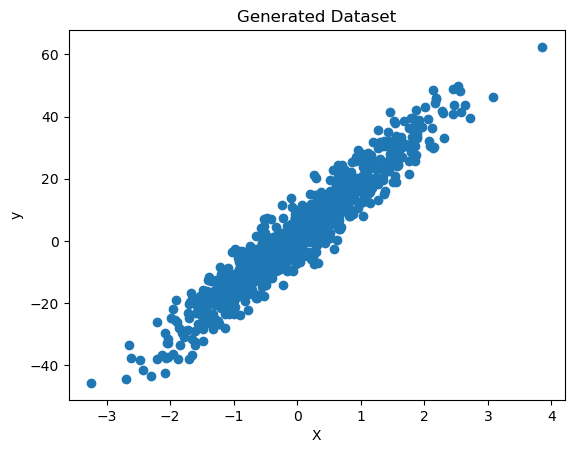

In [31]:
# plot the generated data
plt.scatter(X,y)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated Dataset')
plt.show()

In [32]:
# what is the model parameter?
coef

array(16.74825823)

In [33]:
# add bias term
b = np.ones((X.shape[0],1))
X = np.concatenate((b,X),axis=1)

# reshape true labels
y = y.reshape(-1,1)

### Mini-Batch Gradient Descent with MSE Loss

In [38]:
w, w_path = mini_batch_gradient_descent(X, y, model, mse_gradient, n_batches=20, epochs=100, verbose=True)

Error metrics: MSE = 24.53, MAE = 3.95
Final weights: 1.94, 16.82


In [35]:
w_path1 = np.array(w_path)

In [37]:
w_path2 = np.array(w_path)

In [39]:
w_path3 = np.array(w_path)

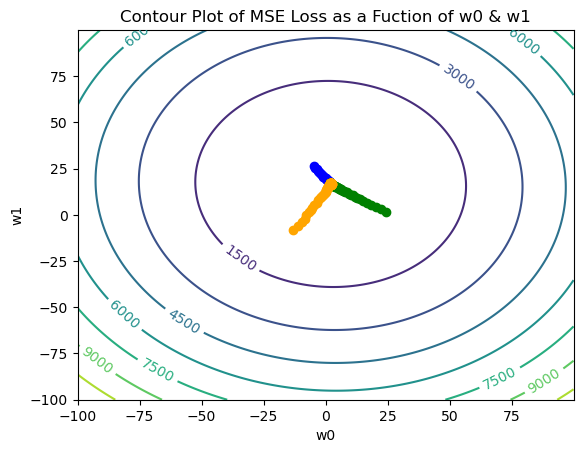

In [40]:
fig, ax = plt.subplots()
CS = ax.contour(w0, w1, loss_mse)
ax.clabel(CS, inline=True, fontsize=10)
plt.scatter(w_path1[:,0],w_path1[:,1],c='blue')
plt.scatter(w_path2[:,0],w_path2[:,1],c='green')
plt.scatter(w_path3[:,0],w_path3[:,1],c='orange')
ax.set_title('Contour Plot of MSE Loss as a Fuction of w0 & w1')
ax.set_xlabel('w0')
ax.set_ylabel('w1')
plt.show()

The above plot shows the progression of the weights towards the global minimum at (2.0, 16.75), from the initial starting points. Note that all 3 trails converge to the same minimal point, and the presence of a small random component in each path.

### Mini-Batch Gradient Descent with Trignometric Function

In [45]:
w, w_path = mini_batch_gradient_descent(X, y, model, trig_gradient, n_batches=20, 
                                        lr=0.01, epochs=1000, verbose=True)

Error metrics: MSE = 6426.70, MAE = 80.01
Final weights: 82.02, 17.20


In [42]:
w_path1 = np.array(w_path)

In [44]:
w_path2 = np.array(w_path)

In [46]:
w_path3 = np.array(w_path)

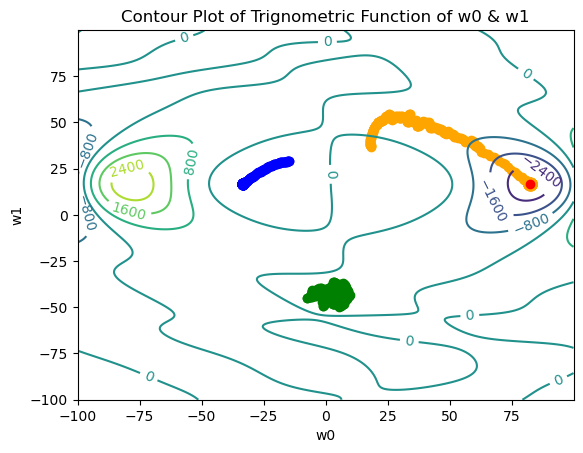

In [47]:
fig, ax = plt.subplots()
CS = ax.contour(w0, w1, loss_tri)
ax.clabel(CS, inline=True, fontsize=10)
plt.scatter(w_path1[:,0],w_path1[:,1],c='blue')
plt.scatter(w_path2[:,0],w_path2[:,1],c='green')
plt.scatter(w_path3[:,0],w_path3[:,1],c='orange')
plt.scatter(np.array([w0_min]),np.array([w1_min]),c='red')
ax.set_title('Contour Plot of Trignometric Function of w0 & w1')
ax.set_xlabel('w0')
ax.set_ylabel('w1')
plt.show()

We can see the 3 trials indicated by the blue, orange, and green trails. With this function, finding the global minimum proves to be difficult, and the position settled upon by the algorithm is strongly dependent on the initial starting position. Two out of three trials (blue & green) find two different local minima in weight space. The orange trial manages to find the global minima.